In [1]:
import pandas as pd
import geopandas as gpd
from choicemodels import MultinomialLogit, MultinomialLogitResults
from choicemodels.tools import MergedChoiceTable

In [2]:
gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_06_tract.zip")

<AxesSubplot:>

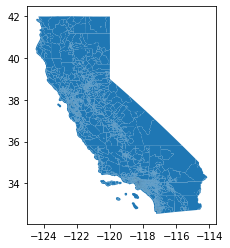

In [3]:
gdf.plot()

In [24]:
# store = pd.HDFStore('../data/custom_mpo_06197001_model_data.h5')
# hh = store['households']
# blocks = store['blocks']
# persons = store['persons']

In [25]:
hh['own'] = hh['tenure'] == 1
hh['tract_id'] = hh['block_id'].str[:11]

In [26]:
hh.to_csv('households.csv')

In [27]:
hh = pd.read_csv('households.csv', index_col=0, dtype={'block_id':str})

In [31]:
hh_w_blocks = hh.merge(blocks[[col for col in blocks.columns if col != 'tract_id']], left_on='block_id', right_index=True)

In [32]:
hh_tracts = hh_w_blocks.groupby('tract_id').agg(
    avg_hh_income=('income', 'mean'),
    total_cars=('cars', 'sum'),
    total_persons=('persons', 'sum'),
    total_households=('persons', 'count'),
    total_workers=('workers','sum'),
    total_owners=('own','sum'),
    total_land=('square_meters_land','sum')
)

In [33]:
persons['white'] = persons['race'] == 'white'

In [34]:
p_w_blocks = pd.merge(persons, hh_w_blocks[blocks.columns], left_on='household_id', right_index=True)

In [35]:
p_tracts = p_w_blocks.groupby('tract_id').agg(
    avg_age=('age','mean'),
    total_white=('white','sum'),
)

In [36]:
p_hh_tract = pd.merge(p_tracts, hh_tracts, left_index=True, right_index=True)

In [37]:
p_hh_tract.eval('pop_density = total_persons / total_land', inplace=True)
p_hh_tract.eval('pct_white = total_white / total_persons', inplace=True)
p_hh_tract.eval('pct_hh_own = total_owners / total_persons', inplace=True)

In [39]:
p_hh_tract.to_csv('tracts.csv')

In [40]:
obs_sample_size = 1000

In [41]:
mct = MergedChoiceTable(hh.sample(obs_sample_size), p_hh_tract, chosen_alternatives='tract_id')

In [52]:
results = MultinomialLogit(
    mct, model_expression='income*avg_hh_income + cars + age_of_head + own*pct_hh_own + sf_detached*pct_white')

In [53]:
model = results.fit()

       -2.54636932e+06, -2.26687872e+12, -3.18253431e-12, -2.97040170e-11,
       -3.74445228e+00, -1.94968614e+01, -1.84348747e+01, -2.70544990e+01]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2})


In [54]:
model

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          1,000
Model:         Multinomial Logit   Df Residuals:                988
Method:       Maximum Likelihood   Df Model:                     12
Date:                 2021-09-19   Pseudo R-squ.:             0.000
Time:                      02:12   Pseudo R-bar-squ.:        -0.002
AIC:                  14,751.827   Log-Likelihood:       -7,363.914
BIC:                  14,810.720   LL-Null:              -7,363.914
                                  coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------
Intercept                       0.0000     0.203     0.000     1.000             
own[T.True]                     0.0000     0.199     0.000     1.000             
sf_detached[T.yes]              0.0000     0.201     0.000     1.000             
income                          0.0000     0.0

In [45]:
MultinomialLogitResults(probabilities(mct)

AttributeError: 'MultinomialLogit' object has no attribute 'probabilities'